In [28]:
import os
import pulp
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.decomposition import PCA

In [2]:
def get_mbs_data() -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    mbs_path = os.path.join(data_path, "MBS.parquet")

    renamer = {
        "LUMSMD": "MBS_mod_dur",
        "LUMSOAS": "MBS_oas",
        "LUMSTRUU": "MBS_index"}

    df_mbs = (pd.read_parquet(
        path = mbs_path, engine = "pyarrow").
        rename(columns = renamer).
        reset_index().
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        set_index("date"))
    
    return df_mbs

df_mbs = get_mbs_data()

In [3]:
def get_tsy_data() -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    tsy_path = os.path.join(data_path, "tsy.parquet")

    df_tsy = (pd.read_parquet(
        path = tsy_path, engine = "pyarrow").
        rename(columns = {
            "CONVENTIONAL_CTD_FORWARD_FRSK": "ctd_duration",
            "FUT_EQV_CNVX_NOTL": "ctd_convexity"}).
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        set_index("date"))
    
    return df_tsy

df_tsy = get_tsy_data()

# Treasury Trend Following Models

Start by creating a series of Treasury Trend following models. To simplify these models we'll use a simplified EMA Crossover. The complexity of the trend following models is not of upmost importance. The approach to this model is to show that some added modelling of the treasury-leg of the MBS basis can lead to a suitable outperformance. I'll use the following moving averages [64&256, 32&128, 16&64, 8&32]. These windows are the windows prescribed within the Advanced Futures Trading Strategies - Carver book (pg.186).

In [125]:
def _trend(df: pd.DataFrame, short_window: int, long_window: int) -> pd.DataFrame: 

    '''
    Trend Function per specific security and specific lookback windows
    '''
    
    df_out = (df.sort_index().assign(
        short_ma = lambda x: x.PX_LAST.ewm(span = short_window, adjust = False).mean(),
        long_ma = lambda x: x.PX_LAST.ewm(span = long_window, adjust = False).mean(),
        price_std = lambda x: x.PX_LAST.ewm(span = long_window, adjust = False).std(),
        signal = lambda x: (x.short_ma - x.long_ma) / x.price_std,
        lag_signal = lambda x: x.signal.shift(),
        short_window = short_window,
        long_window = long_window).
        drop(columns = ["short_ma", "long_ma", "price_std"]).
        dropna())
    
    return df_out
    
def _get_trend_signal(df: pd.DataFrame, lookback_windows: list) -> pd.DataFrame:
    
    '''
    Trend Function per security and n lookback windows
    '''
    
    df_out = (pd.concat([_trend(
        df, lookback_window["short_window"], lookback_window["long_window"])
        for lookback_window in lookback_windows]).
        drop(columns = ["security"]))
    
    return df_out

def get_trend_signal(df_tsy: pd.DataFrame, start: int = 3, stop: int = 7) -> pd.DataFrame: 
    
    '''
    Trend function n securities and n lookback windows
    '''
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    path = os.path.join(data_path, "TreasuryTrend.parquet")
    
    try: 
        
        df_trend = pd.read_parquet(path = path, engine = "pyarrow")
    
    except: 
    
        lookback_windows = [
            {"short_window": 2 ** i, "long_window": 2 ** (i + 2)} 
            for i in range(start, stop)]

        df_trend = (df_tsy.drop(
            columns = ["ctd_duration", "ctd_convexity"]).
            groupby("security").
            apply(_get_trend_signal, lookback_windows).
            reset_index())

        df_trend.to_parquet(path = path, engine = "pyarrow")
        
    return df_trend

df_trend = get_trend_signal(df_tsy)

In [5]:
def get_longer_strat(df: pd.DataFrame) -> pd.DataFrame:
    
    df_longer = (df_trend.assign(
        strat = lambda x: 
        x.security + " " + 
        x.short_window.astype(str) + "&" + x.long_window.astype(str))
        [["strat", "date", "lag_signal"]])
    
    return df_longer

def get_correaltion_matrix(df_trend: pd.DataFrame) -> pd.DataFrame:
    
    df_corr = (get_longer_strat(df_trend).pivot(
        index = "date", columns = "strat", values = "lag_signal").
        cov())
    
    return df_corr

df_corr = get_correaltion_matrix(df_trend)

In [6]:
def get_pca(df_trend: pd.DataFrame) -> pd.DataFrame: 
    
    df_wider = (get_longer_strat(
        df_trend).
        pivot(index = "date", columns = "strat", values = "lag_signal").
        fillna(0))

    df_exp = (pd.DataFrame({
        "PC": [i + 1 for i in range(len(df_wider.columns))],
        "exp_variance": PCA(
            n_components = len(df_wider.columns)).
            fit(df_wider).
            explained_variance_ratio_}).
        set_index("PC"))
    
    return df_exp

df_exp = get_pca(df_trend)

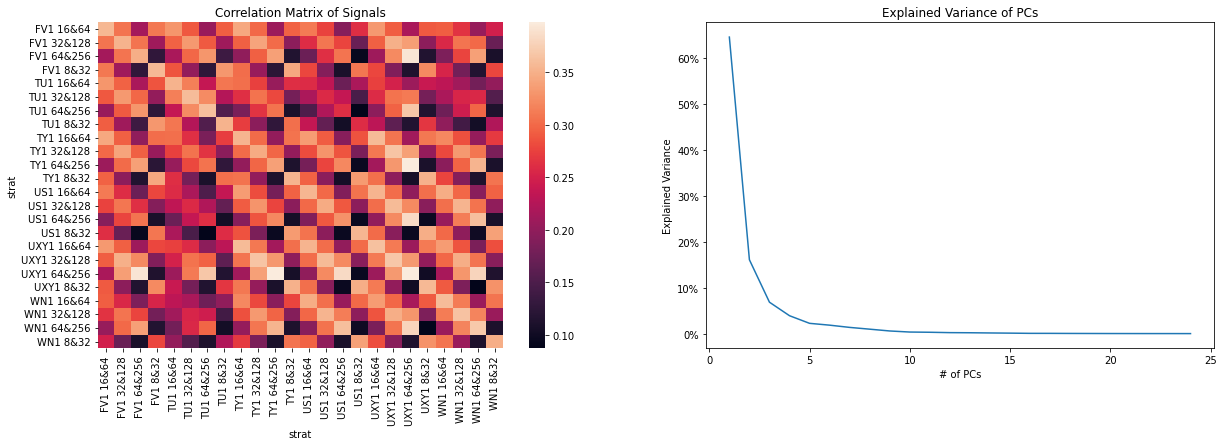

In [7]:
def plot_signal_attributes(df_corr: pd.DataFrame, df_exp: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    sns.heatmap(
        df_corr, 
        ax = axes[0])

    df_exp.plot(
        ax = axes[1],
        xlabel = "# of PCs",
        ylabel = "Explained Variance",
        title = "Explained Variance of PCs",
        legend = False)

    axes[0].set_title("Correlation Matrix of Signals")
    axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    
plot_signal_attributes(df_corr, df_exp)

Although there are various CTA signals and lookbacks, instead of looking at the individual signals of each security start by averaging the signal across securities. Start with a long basis model where we are always picking the CTA that is short the Treasury that is the closest in duration to the MBS. 

In [8]:
def get_avg_trend(df_trend: pd.DataFrame) -> pd.DataFrame:     

    df_avg_trend = (df_trend[
        ["security", "date", "lag_signal"]].
        groupby(["date", "security"]).
        agg("mean").
        reset_index())
    
    return df_avg_trend

df_avg_trend = get_avg_trend(df_trend)

When creating the signal there are a couple of considerations. The first is that certain Treasury Futures have different start dates. That will be left as-is, since that'd be the most accurate to what would've played out and make the backtest more realistic. There are some periods where there aren't any CTA signals that are short treasuries. In that case the optimal Treasury will be the one with lowest signal. Therefore the first model that will be tested is the one that gets the minimum signal of the CTA

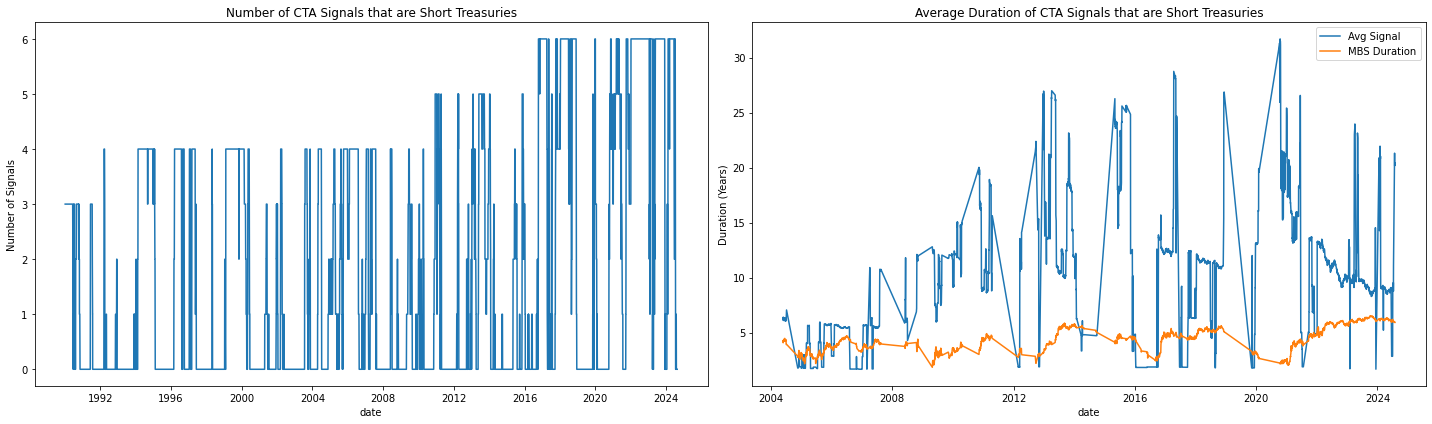

In [9]:
def plot_negative_signal_statistics(df_avg_trend: pd.DataFrame, df_tsy: pd.DataFrame) -> plt.Figure: 
    
    df_num_signals = (df_avg_trend.assign(
        signal = lambda x: np.where(x.lag_signal < 0, 1, 0)).
        drop(columns = ["security", "lag_signal"]).
        groupby("date").
        agg("sum"))

    df_tsy_duration = (df_tsy[
        ["security", "ctd_duration"]].
        dropna())

    df_neg_cta = (df_avg_trend.assign(
        signal = lambda x: np.sign(x.lag_signal)).
        query("signal == -1"))

    df_cta_duration = (df_neg_cta.merge(
        right = df_tsy_duration, how = "inner", on = ["date", "security"]).
        drop(columns = ["lag_signal", "security", "signal"]).
        groupby("date").
        agg("mean").
        merge(right = df_mbs[["MBS_mod_dur"]], how = "inner", on = ["date"]).
        rename(columns = {
            "ctd_duration": "Avg Signal",
            "MBS_mod_dur": "MBS Duration"}))

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
    (df_num_signals.plot(
        ax = axes[0],
        legend = False,
        ylabel = "Number of Signals",
        title = "Number of CTA Signals that are Short Treasuries"))

    (df_cta_duration.plot(
        ax = axes[1],
        ylabel = "Duration (Years)",
        title = "Average Duration of CTA Signals that are Short Treasuries"))
    
    plt.tight_layout()
    
plot_negative_signal_statistics(df_avg_trend, df_tsy)

Its a bit evident that since the short end position bounces around considerably which likely occurs from treasuries buying longer dated treausries that are trending down. This is problematic since their will be a convexity mismatch which leads to a larger duration hedging error. In the next notebook this problem will be tackled but for the time being let's start by finding this optimal basis. 

In [10]:
def _get_min_signal(df: pd.DataFrame) -> pd.DataFrame: return(df.query("lag_signal == lag_signal.min()"))

def get_min_signal(df_tsy: pd.DataFrame, df_avg_trend: pd.DataFrame) -> pd.DataFrame: 

    df_avg_min_signal = (df_tsy.drop(
        columns = ["ctd_convexity", "ctd_duration"]).
        reset_index().
        pivot(index = "date", columns = "security", values = "PX_LAST").
        pct_change().
        reset_index().
        melt(id_vars = "date").
        rename(columns = {"value": "rtn"}).
        merge(right = df_tsy[["security", "ctd_duration"]], how = "inner", on = ["date", "security"]).
        dropna().
        merge(right = df_avg_trend, how = "inner", on = ["date", "security"]).
        groupby("date").
        apply(_get_min_signal).
        reset_index(drop = True))
    
    return df_avg_min_signal

df_avg_min_signal = get_min_signal(df_tsy, df_avg_trend)

In [ ]:
def plot_signal_duration(df_avg_min_signal: pd.DataFrame, df_mbs: pd.DataFrame) -> plt.Figure: 
    
    df_plot = (df_avg_min_signal.merge(
        right = df_mbs[["MBS_mod_dur"]], how = "inner", on = ["date"]).
        set_index("date")
        [["ctd_duration", "MBS_mod_dur"]].
        rename(columns = {
            "ctd_duration": "Treasury Signal",
            "MBS_mod_dur": "MBS Duration"}))

    fig, axes = plt.subplots(figsize = (12,6))
    (df_plot.plot(
        ax = axes,
        ylabel = "Duration (Years)",
        title = "Duration of Short Treasury Signal vs. MBS Duration from {} to {}".format(
            df_plot.index.min(),
            df_plot.index.max())))

    plt.tight_layout()
    
plot_signal_duration(df_avg_min_signal, df_mbs)

Let's examine the performance of the short legs of the Treasuries

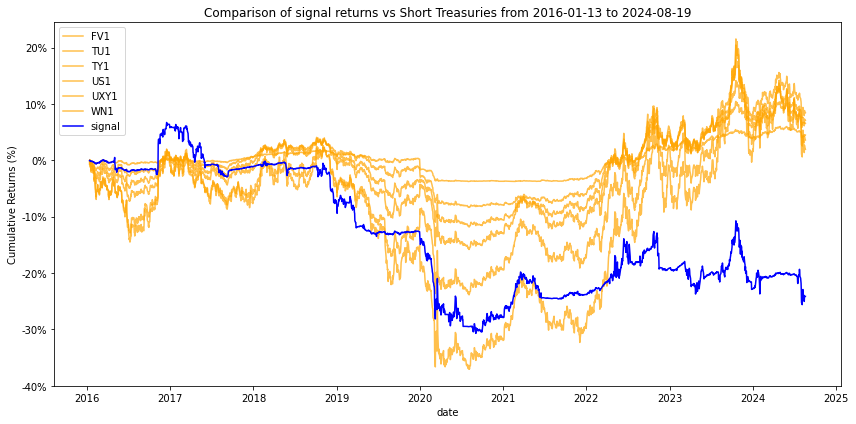

In [12]:
def plot_cumulative_return(df_tsy: pd.DataFrame, df_avg_min_signal: pd.DataFrame, df_mbs: pd.DataFrame) -> plt.Figure: 
    
    df_tsy_rtn = (df_tsy[
        ["security", "PX_LAST"]].
        reset_index().
        pivot(index = "date", columns = "security", values = "PX_LAST").
        pct_change())

    df_combined = (df_tsy_rtn.reset_index().melt(
        id_vars = "date").
        merge(right = df_avg_min_signal, how = "inner", on = ["date", "security"]).
        drop(columns = ["lag_signal"]).
        sort_values("date").
        assign(signal_rtn = lambda x: -1 * x.value).
        set_index("date")
        [["signal_rtn"]].
        merge(right = -1 * df_tsy_rtn, how = "inner", on = ["date"]).
        dropna().
        apply(lambda x: np.cumprod(1 + x) - 1))

    fig, axes = plt.subplots(figsize = (12,6))

    (df_combined.drop(
        columns = ["signal_rtn"]).
        plot(
            ax = axes,
            color = "orange",
            alpha = 0.7))

    (df_combined[
        ["signal_rtn"]].
        rename(columns = {"signal_rtn": "signal"}).
        plot(
            ax = axes,
            ylabel = "Cumulative Returns (%)",
            color = "blue",
            title = "Comparison of signal returns vs Short Treasuries from {} to {}".format(
                df_combined.index.min(),
                df_combined.index.max())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    plt.tight_layout()
    
plot_cumulative_return(df_tsy, df_avg_min_signal, df_mbs)

This is not a fully accurate representation of the short performance since the returns aren't scaled by their optimal duration-hedge weights. For a quick back of the math calculation change the returns from percent change to basis points. 

In [13]:
def _get_bps(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_index().assign(
        bps = lambda x: x.PX_LAST.diff() / x.ctd_duration)
        [["bps"]])

def get_bps(df_tsy: pd.DataFrame, df_avg_min_signal: pd.DataFrame) -> pd.DataFrame: 

    df_bps = (df_tsy.drop(
        columns = ["ctd_convexity"]).
        dropna().
        groupby("security").
        apply(_get_bps).
        reset_index())

    df_min_signal = (df_avg_min_signal.merge(
        right = df_bps, how = "inner", on = ["date", "security"]).
        assign(bps = lambda x: - x.bps).
        dropna()
        [["date", "bps"]].
        rename(columns = {"bps": "signal"}))

    df_tsy_bps = (df_bps.assign(
        bps = lambda x: - x.bps).
        pivot(index = "date", columns = "security", values = "bps"))

    df_cum_bps = (df_min_signal.merge(
        right = df_tsy_bps, how = "inner", on = ["date"]).
        set_index("date").
        dropna().
        cumsum())
    
    return df_cum_bps

df_cum_bps = get_bps(df_tsy, df_avg_min_signal)

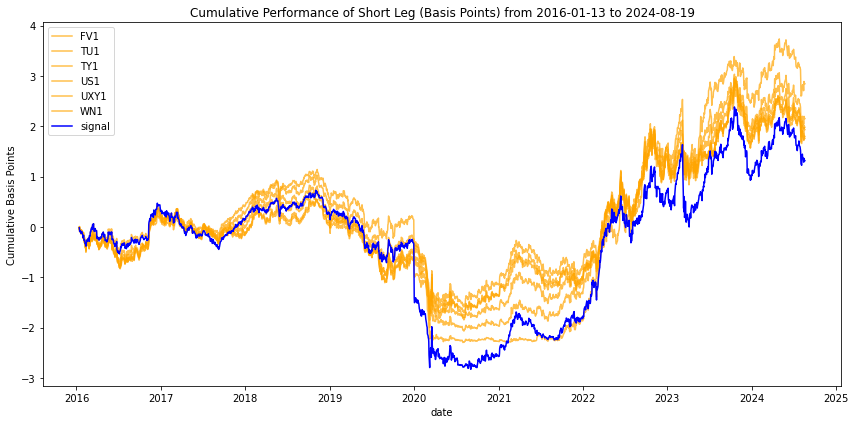

In [14]:
def plot_cumulative_basis_points(df_cum_bps: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_cum_bps.drop(
        columns = ["signal"]).
        plot(
            alpha = 0.7,
            ax = axes,
            color = "orange"))

    (df_cum_bps[
        ["signal"]].
        plot(
            ylabel = "Cumulative Basis Points",
            ax = axes,
            color = "blue",
            title = "Cumulative Performance of Short Leg (Basis Points) from {} to {}".format(
                df_cum_bps.index.min(),
                df_cum_bps.index.max())))

    plt.tight_layout()
    
plot_cumulative_basis_points(df_cum_bps)

Now optimize the weighting to get the actual basis performance. 

In [58]:
def prep_signal_duration(df_avg_min_signal: pd.DataFrame, df_mbs: pd.DataFrame) -> pd.DataFrame:
    
    df_duration = (df_avg_min_signal.sort_values(
        "date").
        assign(lag_duration = lambda x: x.ctd_duration.shift())
        [["date", "lag_duration", "rtn"]].
        dropna())

    df_mbs_prep = (df_mbs.sort_index().assign(
        mbs_rtn = lambda x: x.MBS_index.pct_change(),
        lag_mbs_duration = lambda x: x.MBS_mod_dur.shift()).
        dropna()
        [["mbs_rtn", "lag_mbs_duration"]])

    df_combined = (df_duration.merge(
        right = df_mbs_prep, how = "inner", on = ["date"]))
    
    return df_combined

df_duration_prep = prep_signal_duration(df_avg_min_signal, df_mbs)

In [72]:
def _hedge_basis(df_duration_prep: pd.DataFrame) -> pd.DataFrame: 
    
    mbs_weights, tsy_weights = [], []
    for i, row in df_duration_prep.iterrows():

        duration_problem = pulp.LpProblem(name = "duration_problem", sense = pulp.LpMinimize)
        mbs_weight = pulp.LpVariable(name = "mbs_weight", lowBound = 0.01, upBound = 1)
        tsy_weight = pulp.LpVariable(name = "tsy_weight", lowBound = 0.01, upBound = 1)

        duration_problem += (mbs_weight * row.to_dict()["lag_mbs_duration"]) - (tsy_weight * row.to_dict()["lag_duration"]) == 0
        duration_problem += mbs_weight + tsy_weight == 1

        solve = duration_problem.solve()
        mbs_weights.append(pulp.value(mbs_weight))
        tsy_weights.append(pulp.value(tsy_weight))

    df_out = (df_duration_prep.assign(
        mbs_weight = mbs_weights,
        tsy_weight = tsy_weights).
        drop(columns = ["lag_duration", "lag_mbs_duration"]).
        assign(basis_rtn = lambda x: (x.mbs_weight * x.mbs_rtn) - (x.rtn * x.tsy_weight)))
    
    return df_out

In [76]:
def hedge_basis(df_duration_prep: pd.DataFrame) -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    file_path = os.path.join(data_path, "AvgTrendBasis.parquet")

    try: df = pd.read_parquet(path = file_path, engine = "pyarrow")
    except:

        df = _hedge_basis(df_duration_prep)
        df.to_parquet(path = file_path, engine = "pyarrow")
        
    return df

df_hedge_basis = hedge_basis(df_duration)

In [105]:
def get_generic_basis(df_mbs: pd.DataFrame, df_tsy: pd.DataFrame) -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    weight_path = os.path.join(data_path, "DurationWeights.parquet")

    df_weight_prep = (pd.read_parquet(
        path = weight_path, engine = "pyarrow")
        [["security", "date", "lag_mbs_weight", "lag_tsy_weight"]].
        dropna())

    df_mbs_rtn = (df_mbs.sort_index().assign(
        mbs_rtn = lambda x: x.MBS_index.pct_change())
        [["mbs_rtn"]])

    df_tsy_rtn = (df_tsy[
        ["security", "PX_LAST"]].
        reset_index().
        pivot(index = "date", columns = "security", values = "PX_LAST").
        pct_change().
        reset_index().
        melt(id_vars = "date").
        rename(columns = {"value": "tsy_rtn"}).
        dropna())
    
    df_basis_rtn = (df_weight_prep.merge(
        right = df_mbs_rtn, how = "inner", on = ["date"]).
        merge(right = df_tsy_rtn, how = "inner", on = ["date", "security"]).
        assign(basis_rtn = lambda x: (x.mbs_rtn * x.lag_mbs_weight) - (x.tsy_rtn * x.lag_tsy_weight))
        [["security", "date", "basis_rtn"]].
        pivot(index = "date", columns = "security", values = "basis_rtn"))
    
    return df_basis_rtn

df_basis = get_generic_basis(df_mbs, df_tsy)

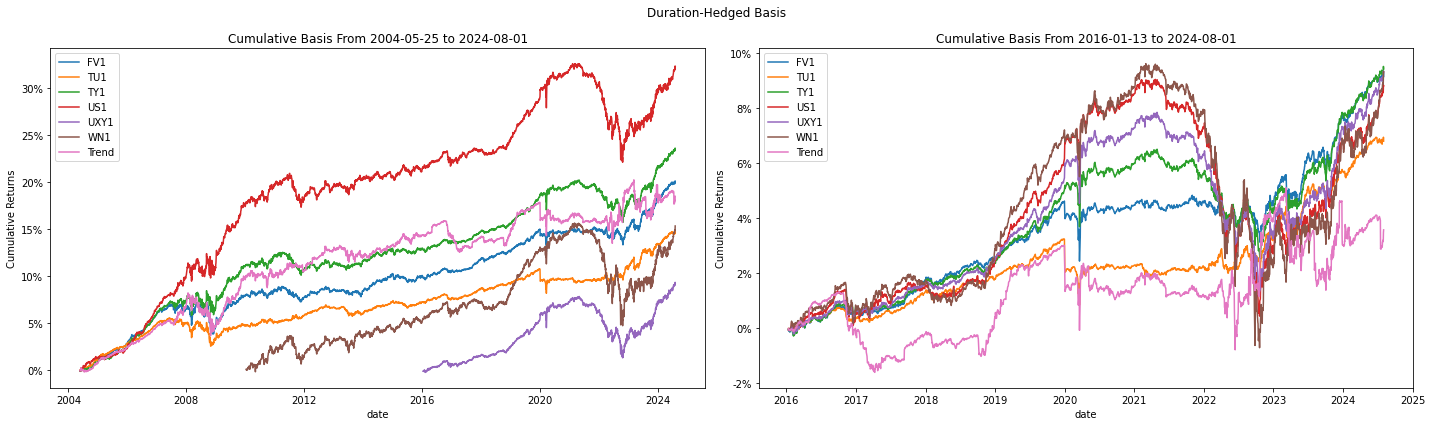

In [124]:
def plot_cumulative_basis(df_basis: pd.DataFrame, df_hedge_basis: pd.DataFrame) -> pd.DataFrame: 
    
    df_combined = (df_basis.merge(
        right = df_hedge_basis, how = "inner", on = ["date"]).
        drop(columns = ["rtn", "mbs_rtn", "mbs_weight", "tsy_weight"]).
        set_index("date").
        rename(columns = {"basis_rtn": "Trend"}))

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_combined.apply(
        lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes[0],
            ylabel = "Cumulative Returns",
            title = "Cumulative Basis From {} to {}".format(
                df_combined.index.min(),
                df_combined.index.max())))

    df_tmp = (df_combined.dropna().apply(
        lambda x: np.cumprod(1 + x) - 1))

    (df_tmp.plot(
        ax = axes[1],
        ylabel = "Cumulative Returns",
        title = "Cumulative Basis From {} to {}".format(
            df_tmp.index.min(),
            df_tmp.index.max())))

    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    fig.suptitle("Duration-Hedged Basis")
    plt.tight_layout()
    
plot_cumulative_basis(df_basis, df_hedge_basis)